# 9. 비지도 학습
- 입력 정보만 사용
- 클러스터링(Clustering), 차원 압축(Dimensionality Reduction), 이상 감지(Anomaly Detection) 등
- 여기서 다룰 것은 **클러스터링**

## 9.1 2차원 입력 데이터
- 클러스터링: **클래스 정보 없이** 입력 데이터가 비슷한 것끼리 클래스로 나누기

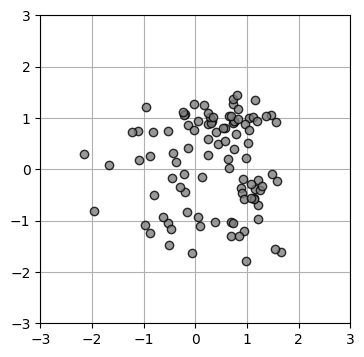

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 생성
np.random.seed(1)
N = 100
K = 3
T3 = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ["cornflowerblue", "black", "white"]
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포 분산
Pi = np.array([0.4, 0.8, 1]) # 누적 확률
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k] + Mu[T3[n, :] == 1, k])

# 데이터 그리기
def show_data(x):
    plt.plot(X[:, 0], x[:, 1], linestyle="none", marker="o", markersize=6, markeredgecolor="black", color="gray", alpha=0.8)
    plt.grid(True)

# 메인
plt.figure(1, figsize=(4, 4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez("data_ch9.npz", X=X, X_range0=X_range0, X_range1=X_range1)

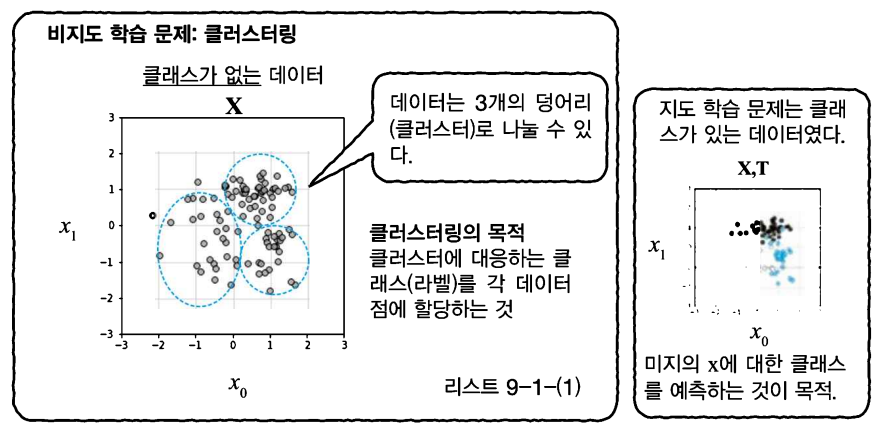

- 분포의 경향성은 위의 그림 참조
- **클러스터**: 이러한 데이터 분포 모양
- 클러스터링
    1. 데이터 분포에서 클러스터 찾기
    2. 동일한 클러스터에 속하는 데이터 점에 같은 클래스(라벨) 붙이기
    3. 다른 클러스터에 속하는 데이터 점에는 다른 클래스 할당
- 클래스 vs 클러스터
    - 클래스: 라벨
    - 클러스터: 분포의 특징
    - 그러나 동의어로 사용되는 경우도 O
- 클러스터링 알고리즘
    - K-means 기법
    - 가우시안 혼합 모델

## 9.2 K-means 기법

### 9.2.1 K-means 기법 개요
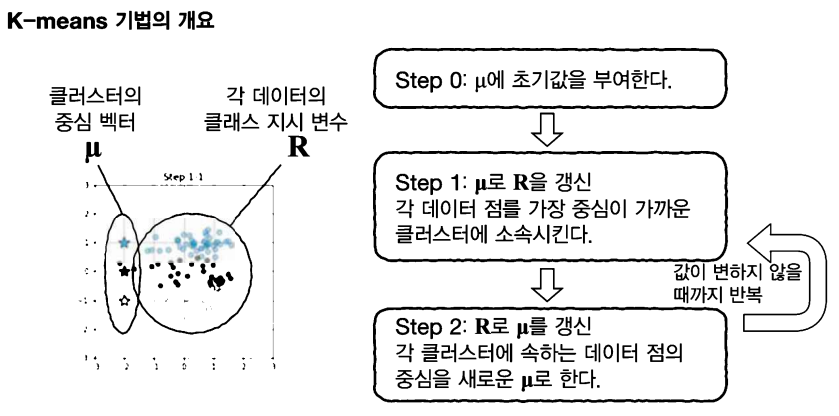

- 미리 분할할 클러스터 수 $K$ 결정 필요
    - 해당 예제에서는 $K=3$으로 가정
- 변수 2개: $\mathbf{μ}, \mathbf{R}$
    - $\mathbf{μ}$: 클러스터 중심 벡터 (클러스터의 중심 위치를 나타냄)
    - $\mathbf{R}$: 클래스 지시 변수 (각 데이터 점이 어떤 클러스터에 속하는지)

1. 클러스터 중심 벡터 $\mathbf{μ}$에 적절한 값 제공
    - 클러스터 중심 잠정적으로 결정됨
2. 클러스터 중심 벡터 $\mathbf{μ}$를 바탕 > 클래스 지시 변수 $\mathbf{R}$ 결정
3. 현 시점에서 클래스 지시 변수 $\mathbf{R}$로 $\mathbf{μ}$ 갱신
3. 2, 3을 번갈아 반복하며 $\mathbf{μ}$와 $\mathbf{R}$의 갱신 반복
    - 값이 변화하지 않게 될 시 반복 종료

### 9.2.2 Step 0: 변수의 준비와 초기화

- $k$번째 클러스터의 중심 벡터
    - 입력 차원이 2차원 > 클러스터 중심 2차원 벡터
    - 중심 벡터: 알고리즘 최초에 적당한 초기값 제공
$$\mathbf{μ}_k=[μ_{k0}, μ_{k1}] \quad (k=0, 1, 2)$$
- $K=3$이므로 3개의 중심 벡터를 $\mathbf{μ}_0=[-2, 1], \mathbf{μ}_1=[-2, 0], \mathbf{μ}_2=[-2, -1]$로 지정
- 클래스 지시 변수 $\mathbf{R}$: 각 데이터가 어느 클래스에 속해 있는지를 1-of-K 부호화법으로 나타낸 행렬
$$r_{nk} = \begin{cases} 0 & 데이터 \, n이 \, k에 \, 속하는 \, 경우 \\ 1 &데이터 \, n이 \, k에 \, 속하지 \, 않는 \, 경우 \end{cases}$$
- 데이터 $n$에 대한 클래스 지시 변수를 벡터로 나타낼 시
    - 클래스 0에 속하는 경우는
$$\mathbf{r}_n = [r_{n0}, r_{n1}, r_{n2}] = [1, 0, 0]$$
    - 모든 데이터를 정리해서 행렬로 나타낼 시
$$ \mathbf{R} = \left[\begin{matrix} r_{00} & r_{01} & r_{02} \\ r_{10} & r_{11} & r_{12} \\ \vdots & \vdots & \vdots \\ r_{n-1, 0} & r_{n-1, 1} & r_{n-1, 2} \end{matrix} \right] = \left[\begin{matrix} 1 & 0 & 0 \\ 0 & 0 & 1 \\ \vdots & \vdots & \vdots \\ 1 & 0 & 0 \end{matrix} \right] $$

In [2]:
# Mu 및 R 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) # (A) 3개의 μ_k를 한 덩어리로 묶은 3*2 행렬
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] # (B) 모든 데이터가 클래스 0에 속하도록 R 초기화
                                                                   # R은 Mu로 결정되기 때문에 어떻게 초기화하든 다음 알고리즘 결과에 영향 X

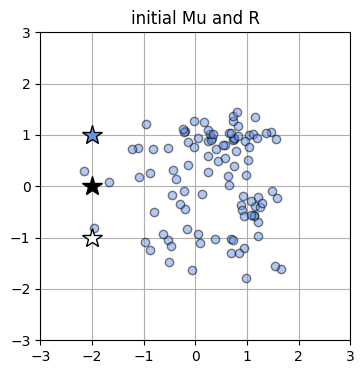

In [3]:
# 데이터 그리는 함수
def show_prm(x, r, mu, col):
    for k in range(K):
        # 데이터 분포 묘사
        plt.plot(x[r[:, k] == 1, 0], x[r[:, k] == 1, 1], marker="o", markerfacecolor=X_col[k], markeredgecolor="k", markersize=6, alpha=0.5, linestyle="none")
        # 데이터 평균을 *로 묘사
        plt.plot(mu[k, 0], mu[k, 1], marker="*", markerfacecolor=X_col[k], markersize=15, markeredgecolor="k", markeredgewidth=1)
        plt.xlim(X_range0)
        plt.ylim(X_range1)
        plt.grid(True)

plt.figure(figsize=(4, 4))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
show_prm(X, R, Mu, X_col)
plt.title("initial Mu and R")
plt.show()

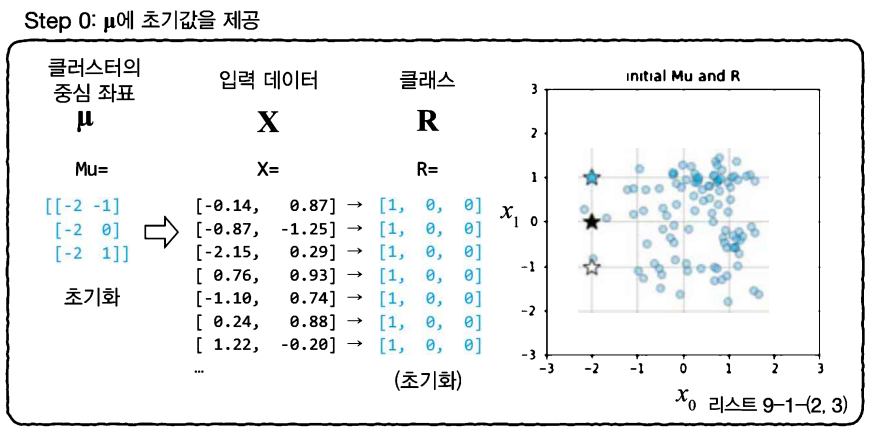

### 9.2.3 Step 1: R의 갱신
$\mathbf{R}$의 갱신 방법
> "각 데이터 점을 가장 중심이 가까운 클러스터에 넣는다."

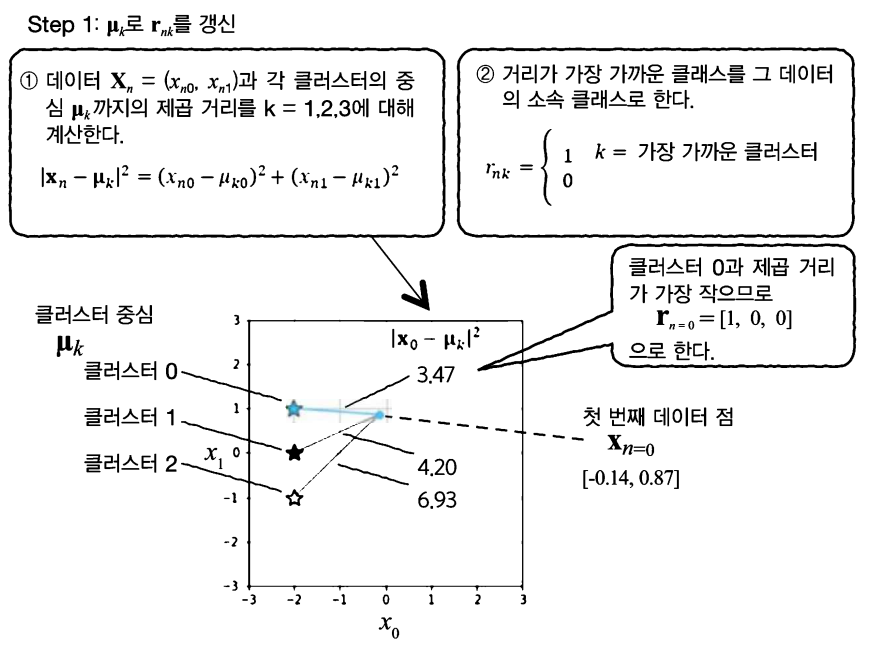

- 첫 번째$(n=0)$의 데이터 점 $[-0.14, 0.87]$에 주목
- 첫 번째 데이터 점에서 클러스터 중심까지의 제곱 거리를 각 클러스터에 대해 계산
    - 데이터 점에서 가장 가까운 클러스터를 알고 싶음 > 제곱근 계산 생략한 제곱 거리 비교
$$|\mathbf{x}_n-\mathbf{μ}_k|^2 = (x_{n0}-μ_{k0})^2 + (x_{n1} - μ_{k1})^2 \quad (k=0, 1, 2) $$
- 제곱 거리 3.47, 4.20, 6.93 > 가장 거리가 가까운 것은 클러스터 0 > $r_{n=0}=[1, 0, 0]$

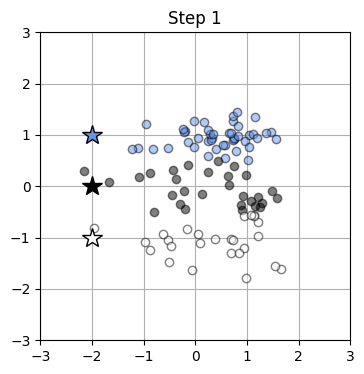

In [4]:
# r을 정한다 (Step 1)
def step1_kmeans(x0, x1, mu):
    N = len(x0)
    r = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = (x0[n] - mu[k, 0]) ** 2 + (x1[n] - mu[k, 1]) ** 2
        r[n, np.argmin(wk)] = 1
    return r

plt.figure(figsize=(4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title("Step 1")
plt.show()

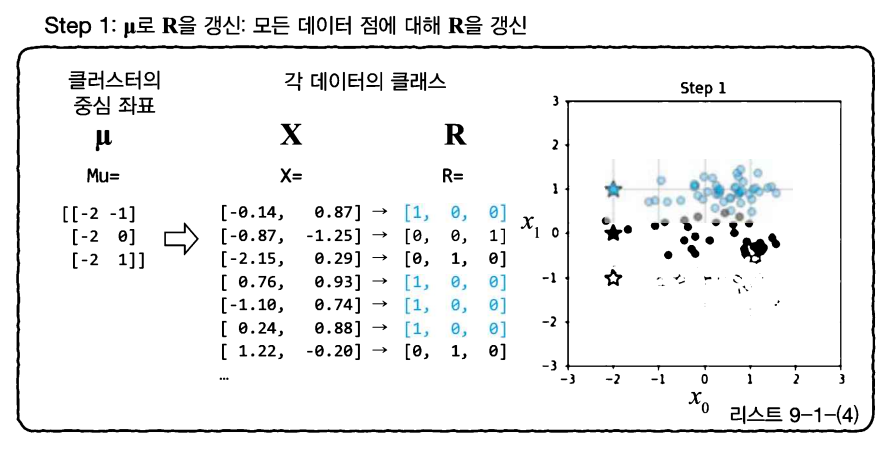

### 9.2.4 Step 2: μ의 갱신
$\mathbf{μ}$의 갱신 방법
> "각 클러스터에 속하는 데이터 점의 중심을 새로운 $\mathbf{μ}$로 한다."

- $k=0$에 속하는 데이터, 즉 $\mathbf{r}_n=[1, 0, 0]$의 라벨을 가진 데이터 점에 주목해 각 평균을 구함
    - 클러스터 0에 속하는 데이터 $n$의 합을 취함
$$μ_{k=0, 0}=\frac{1}{N_k}\sum_{\text{n in cluster 0}}x_{n0}, \quad μ_{k=0, 1}=\frac{1}{N_k}\sum_{\text{n in cluster 0}}x_{n1}$$
- $k=1$과 $k=2$에 대응할 수 있도록 일반화 시
$$μ_{k, 0}=\frac{1}{N_k}\sum_{\text{n in cluster k}}x_{n0}, \quad μ_{k=k, 1}=\frac{1}{N_k}\sum_{\text{n in cluster k}}x_{n1} \quad (k=0, 1, 2)$$

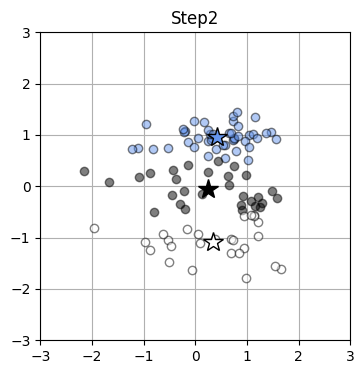

In [5]:
# Mu 결정 (Step 2)
def step2_kmeans(x0, x1, r):
    mu = np.zeros((K, 2))
    for k in range(K):
        mu[k, 0] = np.sum(r[:, k] * x0) / np.sum(r[:, k])
        mu[k, 1] = np.sum(r[:, k] * x1) / np.sum(r[:, k])
    return mu

plt.figure(figsize=(4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title("Step2")
plt.show()

$μ_k$가 각각의 분포의 중심으로 이동한 것 확인 가능 <br>
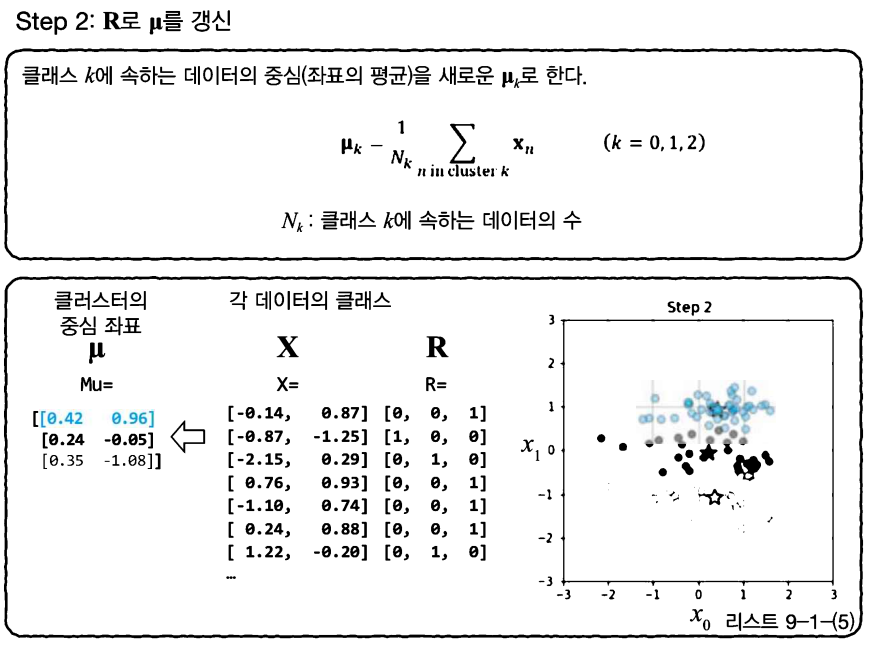

- 이후에는 Step 1과 Step 2의 절차를 반복 > 변수의 값이 변화하지 않으면 프로그램 종료
- 다음 예시에서는 6회 반복 후 종료

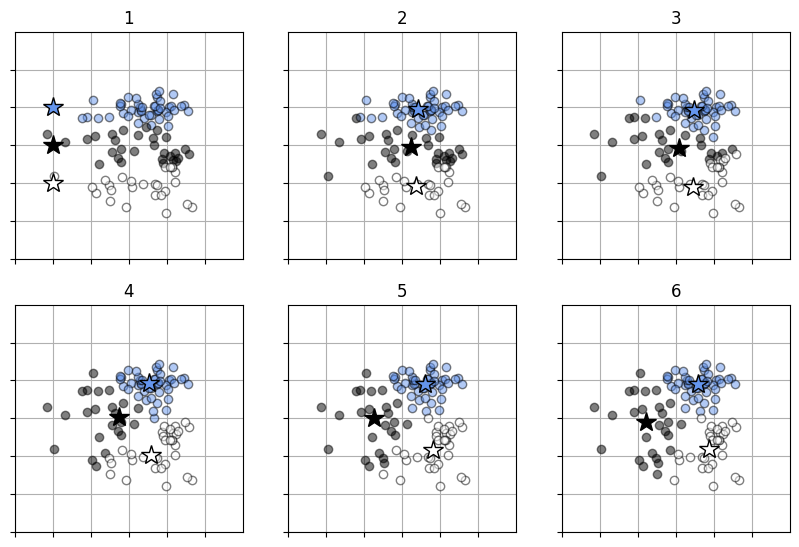

In [6]:
plt.figure(1, figsize=(10, 6.5))
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
max_it = 6 # 반복 횟수
for it in range(0, max_it):
    plt.subplot(2, 3, it+1)
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    show_prm(X, R, Mu, X_col)
    plt.title("{0:d}".format(it+1))
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "")
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
plt.show()

- $μ_k$가 3개의 클러스터의 중심으로 이동하고, 각 클러스터마다 다른 라벨 할당된 것을 관찰 가능

### 9.2.5 왜곡 척도
- 비지도 학습의 오차 함수처럼 학습 진행에 따라 감소하는 목적 함수가 없을까?

- 데이터 점이 속한 클러스터의 중심까지의 제곱 거리를 전체 데이터로 합한 것: 목적 함수에 대응
- **왜곡 척도**라는 명칭
$$J = \sum_{\text{n in cluster 0}}|\mathbf{x}_n-\mathbf{μ}_0|^2 + \sum_{\text{n in cluster 1}}|\mathbf{x}_n-\mathbf{μ}_1|^2 + \sum_{\text{n in cluster 2}}|\mathbf{x}_n-\mathbf{μ}_2|^2$$

합의 기호를 사용하여 정리 시
$$J = \sum_{k=0}^2\sum_{\text{n in cluster k}}|\mathbf{x}_n-\mathbf{μ}_k|^2$$

$r_{nk}$는 데이터 $n$이 속한 클러스터에서만 1, 속하지 않는 클러스터에서는 0이 되는 변수라는 사실을 이용하면
$$J = \sum_{n=0}^{N-1}\sum_{k=0}^{K-1}r_{nk}|\mathbf{x}_n-\mathbf{μ}_k|^2$$

In [7]:
# 목적 함수
def distortion_measure(x0, x1, r, mu):
    # 입력 2차원으로 제한
    N = len(x0)
    J = 0
    for n in range(N):
        for k in range(K):
            J = J + r[n, k] * ((x0[n] - mu[k, 0]) ** 2 + (x1[n] - mu[k, 1]) ** 2)
    return J
# test
# Mu와 R의 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
distortion_measure(X[:, 0], X[:, 1], R, Mu)

771.7091170334878

- 초기값의 왜곡 척도 표시됨

- K-means 기법의 반복에 의한 왜곡 척도 계산 시

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


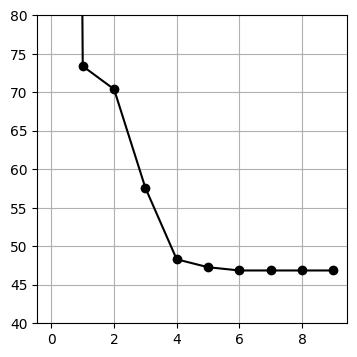

In [8]:
# Mu와 R의 초기화
N = X.shape[0]
K = 3
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
max_it = 10
it = 0
DM = np.zeros(max_it) # 왜곡 척도의 계산 결과 대입
for it in range(0, max_it): # K-means 기법
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu) # 왜곡 척도
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
print(np.round(DM, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(DM, color="black", linestyle="-", marker="o")
plt.ylim(40, 80)
plt.grid(True)
plt.show()

- Step을 진행할수록 왜곡 척도 점차 감소
- Step 6에서 값이 46.86에서 중지
    - μ와 R의 값 변화 X
- K-means 기법으로 얻는 해: 초기값 의존성
    - 처음 μ에 무엇을 할당하는지에 따라 결과가 달라짐
    - 다양한 μ에서 시작해서 얻은 결과 중 가장 왜곡 척도가 작은 결과를 사용하는 방법 사용
- μ와 R 중 무엇을 먼저 정하든 상관 X
    - R을 먼저 정할 경우 > R로부터 μ를 찾아가는 절차가 됨

## 9.3 가우시안 혼합 모델

### 9.3.1 확률적 클러스터링
- K-means 기법은 데이터 점을 **반드시 클러스터에 할당**
- 모호성을 포함해서 수치화할 경우
    - 데이터 점 A는 확실히 클러스터 0에 속하지만, 데이터 점 B는 클러스터 0과 클러스터 1에 모두 속해 있다.
    - **확률**의 개념 도입
- 데이터 점 A가 클러스터 0에 속할 확률 0.9, 클러스터 1에 속할 확률 0.1, 클러스터 2에 속할 확률 0.0
$$\mathbf{γ_A} = [γ_{A0}, γ_{A1}, γ_{A2}] = [0.9, 0.1, 0.0]$$
    - 어떤 쪽의 클러스터에는 반드시 속함 > 3개의 확률을 더하면 1
    - K-means 기법으로 다룬 $\mathbf{R}$의 확장
- 클러스터 0의 가장자리에 있는 데이터 B > 클러스터 0에 속할 가능성을 작은 수치로 표현 가능
$$\mathbf{γ_B} = [γ_{B0}, γ_{B1}, γ_{B2}] = [0.5, 0.4, 0.1]$$

- **클러스터 $k$에 속할 확률**의 의미 <br>
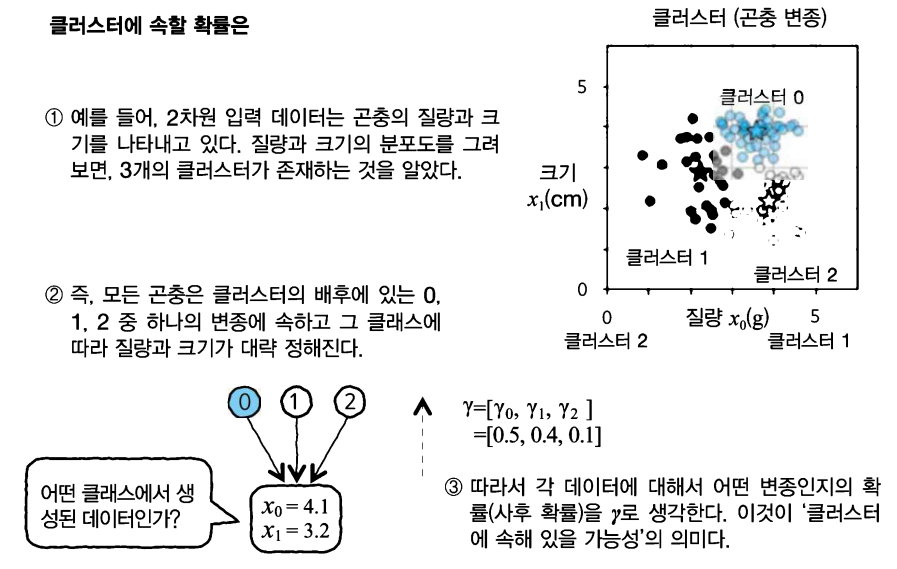

- 같은 종류의 곤충 200마리를 모아 플롯한 결과, 3개의 클러스터 관찰
- 수집한 곤충이 실은 *적어도 세 가지의 변종이 있었다*
- 모든 곤충은 어떤 쪽의 변종에 속해 있으며, 이에 따라 질량과 크기가 정해짐
- **3개의 클러스터의 뒤에 3개의 클래스의 존재 암시**
- 관찰은 못했지만 데이터에 영향을 준 변수를 **잠재 변수** 또는 **숨은 변수**라고 함

- 잠재 변수를 3차원 벡터를 사용하여 1-of-K 부호화법으로 표현 시
$$\mathbf{z}_n = [z_{n0}, z_{n1}, z_{n2}]$$
- 데이터 $n$이 클래스 $k$에 속한다면 $\mathbf{z}_{nk}$만 1을 취하고, 다른 요소는 0이 됨
    - $n$번째 데이터가 클래스 0에 속할 시 $\mathbf{z}_n=[1, 0, 0]$
    - 클래스 1에 속할 시 $\mathbf{z}_n=[0, 1, 0]$
    - 모든 데이터를 정리해서 행렬로 나타낼 시 $\mathbf{Z}$로 표시
        - K-means 기법의 $\mathbf{R}$과 거의 동일함
        - 잠재 변수를 강조하여 $\mathbf{Z}$로 표시

- 데이터 $n$이 클러스터 $k$에 속할 확률 $γ_{nk}$ = 데이터 $xn$인 곤충이 클래스 $k$의 변종일 확률
$$γ_{nk} = P(z_{nk}=\mathbf{1|x}_n)$$
- 관찰할 수 없는 $\mathbf{Z}$의 추정치가 $\mathbf{γ}$이다.
    - $\mathbf{Z}$: 어떤 클래스에 속하고 있는가 (0 or 1의 값)
    - $\mathbf{γ}$: 확률적인 추정값 (0~1의 실수)
    - $\mathbf{γ}$는 어떤 클러스터에 얼마나 기여하고 있는가 > **부담률**

- 확률적 클러스터링: 데이터의 배후에 숨어 있는 잠재 변수 $\mathbf{Z}$를 확률적으로 $\mathbf{γ}$로 추정하는 것

### 9.3.2 가우시안 혼합 모델
부담률 $\mathbf{γ}$를 구하기 위한 가우시안 혼합 모델

- 가우시안 혼합 모델: 2차원 가우스 함수 여러 개를 합친 것
$$p(\mathbf{x}) = \sum_{k=0}^{K-1}π_kN(\mathbf{x}|\mathbf{μ}_k, \mathbf{Σ}_k)$$
- $N(\mathbf{x}|\mathbf{μ}_k, \mathbf{Σ}_k)$은 평균 $\mathbf{μ}_k$, 공분산 행렬 $\mathbf{Σ}_k$의 2차원 가우스 함수
- 위의 식은 서로 다른 평균과 공분산 행렬을 가진 2차원 가우스 함수가 $K$개 겹친 분포

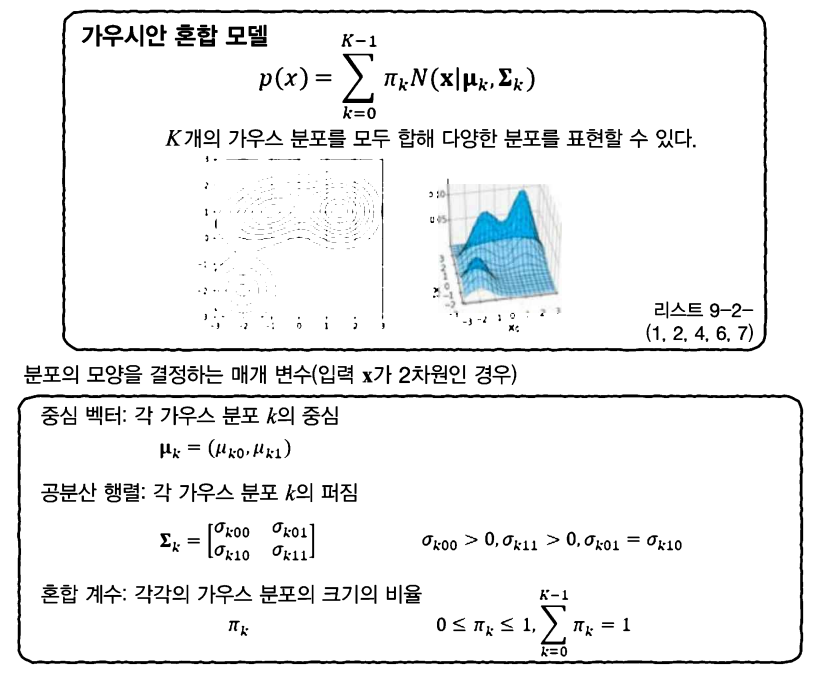

- 위의 그림: $K=3$일 때의 가우시안 혼합 모델의 예
- 중심과 분포의 퍼짐이 다른 가우스 분포 3개가 겹치는 형태

- 모델 매개 변수
    - 각 가우스 분포의 중심을 나타내는 중심 벡터 $\mathbf{μ}_k$
    - 분포의 퍼짐을 나타내는 공분산 행렬 $Σ_k$
    - 각 가우스 분포의 크기의 비율을 나타내는 혼합 계수 $π_k$
        - 혼합 계수는 0~1 사이의 실수, K로 합을 취해 1이 되어야 함
$$\sum_{k=0}^{K-1}π_k=1$$

In [9]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [10]:
import numpy as np
wk = np.load("data_ch9.npz")
X = wk["X"]
X_range0 = wk["X_range0"]
X_range1 = wk["X_range1"]

# 가우스 함수
def gauss(x, mu, sigma):
    N, D = x.shape
    c1 = 1 / (2*np.pi) ** (D/2)
    c2 = 1 / (np.linalg.det(sigma) ** (1/2))
    inv_sigma = np.linalg.inv(sigma)
    c3 = x - mu
    c4 = np.dot(c3, inv_sigma)
    c5 = np.zeros(N)
    for d in range(D):
        c5 = c5 + c4[:, d] * c3[:, d]
    p = c1 * c2 * np.exp(-c5 / 2)
    return p

- ```x```는 $N×D$의 데이터 행렬
- ```mu```는 길이가 $D$인 중심 벡터
- ```sigma```는 $D×D$의 공분산 행렬

- $N=3, D=2$인 데이터 행렬 ```x```
- 길이가 2인 ```mu```
- 2×2의 ```sigma```
- 정의 후 ```gauss(x, mu, sigma)```에 대입 시

In [11]:
x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


- 위의 가우스 함수를 여러 번 더해서 가우시안 혼합 모델을 정의

In [12]:
# 가우시안 혼합 모델
def mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
    return p

- ```x```는 $N×D$의 행렬
- 혼합 계수 ```pi```는 길이 $K$의 벡터
- 중심 벡터 ```mu```는 $K×D$의 행렬
    - $K$개의 가우스 함수의 중심 한 번에 지정
- 공분산 행렬 ```sigma```는 $K×D×D$의 3차원 배열
    - $K$개의 가우스 함수의 공분산 행렬 한꺼번에 지정


In [13]:
# test
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

# 혼합 가우스 등고선 표시
def show_contour_mixgauss(pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, "F"), np.reshape(xx1, xn * xn, "F")]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    plt.contour(x0, x1, f, 10, colors="gray")

# 혼합 가우스 3D 표시
def show3d_mixgauss(ax, pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, "F"), np.reshape(xx1, xn * xn, "F")]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3, color="blue", edgecolor="black")

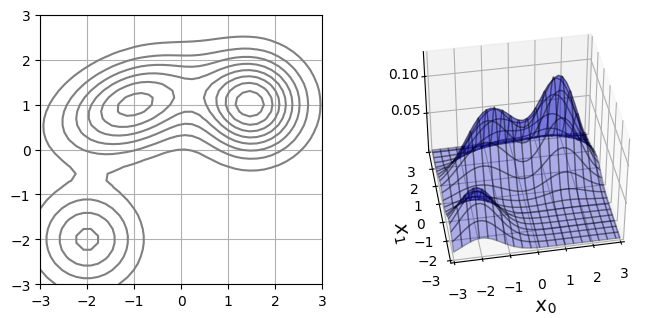

In [15]:
# test
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array([[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])

Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)

Ax = Fig.add_subplot(1, 2, 2, projection="3d")
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel("$x_0$", fontsize=14)
Ax.set_ylabel("$x_1$", fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

### 9.3.3 EM 알고리즘의 개요

- EM 알고리즘: 관측되지 않는 잠재변수에 의존하는 확률 모델 > 최대가능도/최대사후확률 갖는 모수의 추정값을 찾기
- EM 알고리즘을 사용한 가우시안 혼합 모델 데이터 피팅, 부담률 γ 구하기
    - K-means 기법 확장으로 해석 가능

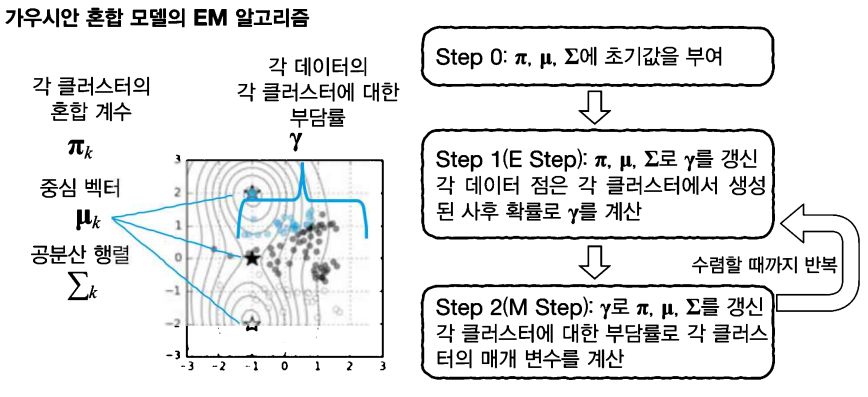

K-means 기법 vs 가우시안 혼합 모델
- 중심 벡터 μ로 클러스터 특정 vs 중심 벡터 μ, 공분산 행렬 Σ를 통한 클러스터 확산 정도 기술 + 혼합 계수 π에 의해 클러스터 크기 차이 설명
- 1-of-K 부호화에서의 $\mathbf{R}$ vs 각 클래스에 속할 확률에 대응하는 부담률 $\mathbf{γ}$

알고리즘
1. $\mathbf{π, μ, Σ}$ 초기화
2. 현시점의 $\mathbf{π, μ, Σ}$ 사용하여 $\mathbf{γ}$ 구하기 (**E**xpectation **Step**)
3. 현시점의 $\mathbf{γ}$를 사용하여 $\mathbf{π, μ, Σ}$ 구하기 (**M**aximazation **Step**)
4. E Step과 M Step을 매개 변수가 수렴할 때까지 반복

### 9.3.4  Step 0: 변수의 준비 및 초기화

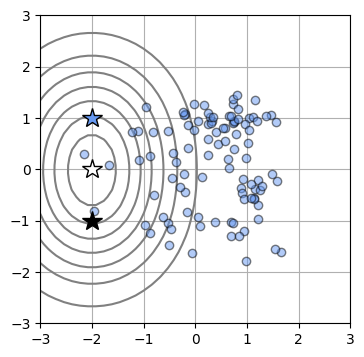

In [17]:
# 초기 설정
N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]

X_col = np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])

# 데이터 그리기
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma)
    for n in range(N):
        col = gamma[n, 0]*X_col[0] + gamma[n, 1]*X_col[1] + gamma[n, 2]*X_col[2]
        plt.plot(x[n, 0], x[n, 1], "o", color=tuple(col), markeredgecolor="black", markersize=6, alpha=0.5)
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker="*", markerfacecolor=tuple(X_col[k]), markersize=15, markeredgecolor="k", markeredgewidth=1)

    plt.grid(True)

plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

- 초기값으로 할당한 중심 벡터 인접 > 3개의 가우스 함수가 겹쳐 세로로 긴 산과 같은 분포

### 9.3.5 Step 1(E Step): γ 갱신

- 부담률 $\mathbf{γ}$를 모든 $n$과 $k$에 대해 갱신
$$γ_{nk}=\frac{π_kN}{∑_k^K, N} \quad γ_{nk}=\frac{π_kN(\mathbf{x}_n|\mathbf{μ}_k, \mathbf{Σ}_k)}{\sum_{k'}^K, N(\mathbf{x}_n|\mathbf{μ}_{k'}, \mathbf{Σ}_{k'})}$$
1. 어떤 데이터 점 $n$에 착안했을 때
2. 해당 데이터 점에서의 각 가우스 함수의 높이 $a_k=π_kN(\mathbf{x}_n|\mathbf{μ}_k, \mathbf{Σ}_k)$ 구하기
3. $k$에서 합을 취해 1이 되도록 $a_k$의 총합 $\sum_{k'}^K, a_{k'}$로 나누어 규격화한 것을 $γ_{nk}$로 함
- **가우스 함수의 값이 높을수록 부담률도 높아진다**는 직관적인 갱신 방법

In [18]:
# gamma를 갱신 (E Step)
def e_step_mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) #KxN
    gamma = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = pi[k] * y[n, k]
        gamma[n, :] = wk / np.sum(wk)
    return gamma

# main
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

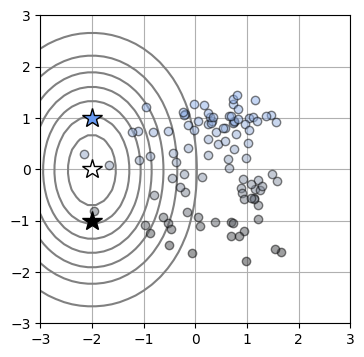

In [19]:
# 표시
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

- 갱신된 부담률은 그라데이션으로 나타냄

### 9.3.6 Step 2 (M Step): π, μ, Σ의 갱신

- 각 클러스터에 대한 부담률의 합 $N_k$를 구함
    - K-means 기법에서 이야기하는 각 클러스터에 속할 데이터의 수 <br>
$$N_k = \sum_{n=0}^{N-1}γ_{nk}$$
- 모든 $n$과 $k$에 대해 갱신한 부담률 $\mathbf{γ}$를 바탕으로 혼합률 $\mathbf{π}_k$를 갱신
    - $N$은 전체 데이터 수
    - 혼합률 > 전체에 대한 클러스터 내 수의 비율
$$π_k^{new} = \frac{N_k}{N}$$
- 중심 벡터 $\mathbf{μ}_k$를 갱신
    - 클러스터에 부담률의 가중치를 더한 데이터의 평균
    - K-means 기법에서의 Step 2(클러스터 데이터의 평균 구하기)에 대응
$$\mathbf{μ}_k^{new} = \frac{1}{N_k}\sum_{n=0}^{N-1}γ_{nk}\mathbf{x}_n$$
- 가우스의 공분산 행렬 갱신
    - 클러스터에 부담률의 가중치를 더한 데이터의 공분산 행렬을 구하는 것
    - 가우스 함수를 데이터에 피팅할 때의 공분산 행렬을 구하는 방법과 유사함
$$\mathbf{Σ}_k^{new} = \frac{1}{N_k}\sum_{n=0}^{N-1}γ_{nk}(\mathbf{x}_n-\mathbf{μ}_k^{new})^{\text{T}}(\mathbf{x}_n-\mathbf{μ}_k^{new})$$

In [20]:
# Pi, Mu, Sigma 갱신 (M Step)
def m_step_mixgauss(x, gamma):
    N, D = x.shape
    N, K = gamma.shape
    # pi 계산
    pi = np.sum(gamma, axis=0) / N
    # mu 계산
    mu = np.zeros((K, D))
    for k in range(K):
        for d in range(D):
            mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])
    # sigma 계산
    sigma = np.zeros((K, D, D))
    for k in range(K):
        for n in range(N):
            wk = x - mu[k, :]
            wk = wk[n, :, np.newaxis]
            sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
        sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])
    return pi, mu, sigma

# main
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

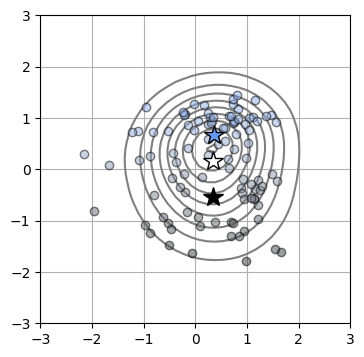

In [21]:
# 표시
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

- 중심 벡터를 나타내는 별표가 훨씬 더 클러스터의 중심으로 이동한 것 확인 가능

- E Step과 M Step 반복하기
- 아래의 코드는 매개 변수 초기값으로 되돌린 후 20회 반복 > 경과 표시 (중심 벡터의 초기값은 분포를 덮도록 변경)

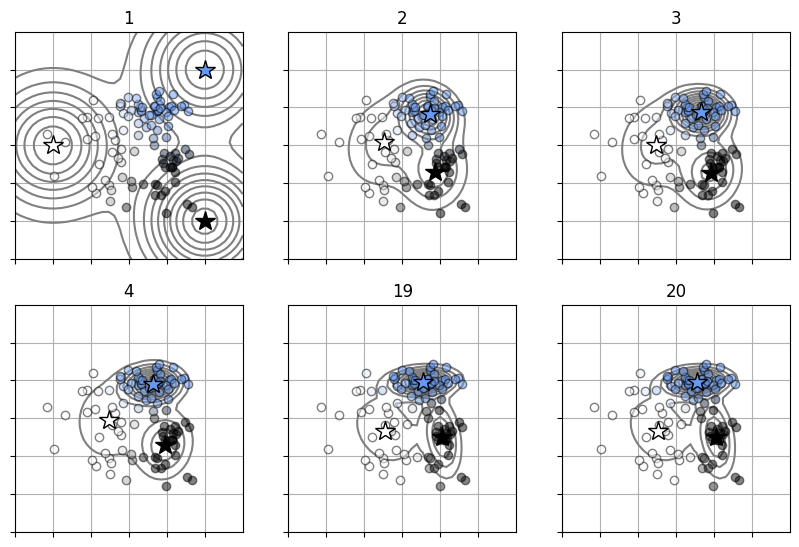

In [24]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.zeros((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize=(10, 6.5))
max_it = 20 # 반복 횟수

i_subplot = 1
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    if it<4 or it>17:
        plt.subplot(2, 3, i_subplot)
        show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
        plt.title("{0:d}".format(it+1))
        plt.xticks(range(X_range0[0], X_range0[1]), "")
        plt.yticks(range(X_range1[0], X_range1[1]), "")
        i_subplot += 1
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)
plt.show()

- 3개의 별에 나타난 중심 벡터 > 클러스터의 중심 부근에 정착
- 각 데이터의 클러스터의 소속이 부담률이라는 확률로 표현 (K-means 기법은 1-of-K 부호화)
    - 데이터 점의 색으로 표시
    - 클러스터의 경계 부근에서는 중간적인 색으로 데이터 표시
- 클러스터링 결과는 매개 변수의 초기값에 따라 달라짐 (K-means 기법과 동일)
    - 다양한 초기값을 사용해서 가장 좋은 결과 선택
- 평가를 위해 **가능도** 사용

### 9.3.7 가능도

- 가우시안 혼합 모델: 데이터 분포 $p(\mathbf{x})$를 나타내는 모델
    - 로지스틱 회귀 모델은 $p(t|\mathbf{x})$와 $\mathbf{x}$에 대해 클래스의 확률을 나타내는 모델 > 클러스터링에서 취급하는 것과 다름
- EM 알고리즘: 가우시안 혼합 모델이 입력 데이터 $\mathbf{X}$의 분포에 맞게 매개 변수 갱신
    - 입력 데이터가 조밀한 부분에 가우스 함수 배치
    - 입력 데이터가 띄엄띄엄한 부분에서 분포의 값이 낮도록 매개 변수 조정
    - 각 가우스 분포가 다른 클러스터 표시
- EM 알고리즘의 최적화: **가능도**
    - 입력 데이터 $\mathbf{X}$는 가우시안 혼합 모델에서 생성 > $\mathbf{X}$가 생성된 확률(가능도)이 가장 높도록 매개 변수 갱신

- 가능도는 모든 데이터 점 $X$가 모델에서 생성된 확률이므로 아래의 식에 할당됨
$$p(\mathbf{X|π, μ, Σ}) = \prod_{n=0}^{N-1}\sum_{k=0}^{K-1}π_kN(\mathbf{x}_n|\mathbf{μ}_k, \mathbf{Σ}_k)$$
- 로그를 취한 로그 가능도는
$$\log p(\mathbf{X|π, μ, Σ}) = \sum_{n=0}^{N-1}\{\log\sum_{k=0}^{K-1}π_kN(\mathbf{x}_n|\mathbf{μ}_k, \mathbf{Σ}_k)\}$$
- -1을 곱한 음의 로그 가능도를 오차 함수 $E$로 정의 (가능도나 로그 가능도를 최적화시킬 때에는 극대화하기 때문에)
$$E(\mathbf{π, μ, Σ}) = -\log p(\mathbf{X|π, μ, Σ}) = -\sum_{n=0}^{N-1}\{\log\sum_{k=0}^{K-1}π_kN(\mathbf{x}_n|\mathbf{μ}_k, \mathbf{Σ}_k)\}$$

- 아래의 코드에서 오차 함수 $E$가 알고리즘 갱신 단계에서 단조롭게 감소했는지 살펴보면

In [25]:
# 혼합 가우스의 목적 함수
def nlh_mixgauss(x, pi, mu, sigma):
    # x: NxD
    # pi: Kx1
    # mu: KxD
    # sigma: KxDxD
    # output 1h: NxK
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    lh = 0
    for n in range(N):
        wk = 0
        for k in range(K):
            wk = wk + pi[k] * y[n, k]
        lh += np.log(wk)
    return -lh

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


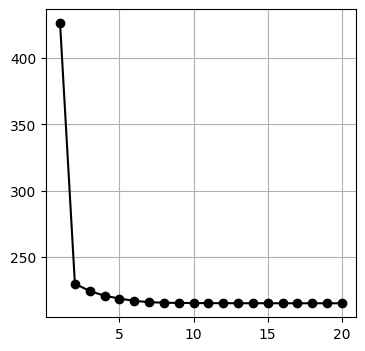

In [27]:
Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]

max_it = 20
it = 0
Err = np.zeros(max_it) # distortion measure
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    Err[it] = nlh_mixgauss(X, Pi, Mu, Sigma)
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

print(np.round(Err, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(np.arange(max_it) + 1, Err, color="k", linestyle="-", marker="o")
plt.grid(True)
plt.show()

- Step 10 정도에서 대부분 수렴
- 음의 로그 가능도를 계산하는 알고리즘이 제대로 작동하고 있는지 확인 가능
- 반복 계산 종료 조건에도 사용 가능
- 다양한 초기값으로 클러스터링 시도 > 가장 좋은 결과 = 음의 로그 가능도가 가장 작은 것